# Example RegtoClass

In this example we show a case study of the work:

[Binarised regression tasks: methods and evaluation metrics](http://link.springer.com/article/10.1007/s10618-015-0443-9)


This work focuses on those supervised tasks that are presented with a numerical output but decisions have to be made in a discrete, binarised, way, according to a particular cutoff. In other words, we have a training dataset as if we were facing a regression task but we have a deployment situation that is a binary classification task. Our proposed approach is easily understood by means of a real life example

## Case Study Dataset

A running example using real mortgages data from Zillow (Zillow API 2013) and real cutoffs from the US Federal Financial Institutions Examination Council (Federal Financial Institutions Examination Council: Home Mortgage Disclosure Act, HMDA 2013) is used throughout the paper. This is a prototypical case of a binarised regression problem where the distributions for the output values and for the cutoffs are similar, as the next figure shows.

![mortages](Zillow-HMDA.jpg)


We start  loading reg2class functions

In [1]:
source("Reg2Class-functions_v1.9.R")

require("quantreg")|| install.packages("quantreg")  # Quantile regression

require("RWeka") || install.packages("RWeka")   # For tree modelling
library(RWeka)  # Classification and Regression techniques: LinearRegression,  M5Rules, M5P, IBk


 

Loading required package: quantreg
Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve



[1] TRUE

Loading required package: RWeka


[1] TRUE

Loading data 

In [2]:
  dat<-read.csv("HousePricesData-Address-City-Features_fromZillow.csv")
  datalen <- nrow(dat)
  mort<-read.csv("MortgagesData_2013_from_HMDA.csv")
  dat=dat[,!colnames(dat) %in% c("street")]
  cutsm<-sort(mort[["LoanAmount"]])
  output_col_name<-"price"
  input_col_names<-names(dat)[1:(length(dat[1,])-1)]

We determine the regression and classification techniques to use

In [3]:
class_technique_names <- c("Clas-LgR", "Clas-kNN", "Clas-J48") 
#class_technique_names <- c("Clas-J48")  
class_technique_names <- c()
all_names <- c(reg_technique_names, class_technique_names)

reg_technique_names <- c("Regr-LnR", "Regr-kNN", "Regr-M5P","Regr-qr")
num_regmodels <- length(reg_technique_names)
num_classmodels <- length(class_technique_names)


ERROR: Error in eval(expr, envir, enclos): object 'reg_technique_names' not found


Split Data

In [4]:

NUM_CUTOFFS_UNIFORM <- -1 # -1 # 100 # -1  # NUM_CUTOFFS_UNIFORM for the UCE plots and the UCE areas. 
#If -1 that means that it will be the same as the number of examples
# General split
DEPLOYPERC <- 0.9 # 0.33         # Percentage of the data for deployment
TRAINPERC <- 1 - DEPLOYPERC
VALPERC <- 0#0.25


dattrainlen <- trunc(datalen*(TRAINPERC))
dattrain <- dat[1:dattrainlen,]

datvallen <- trunc(datalen*(VALPERC))
if (VALPERC > 0) {
  datval <- dat[(dattrainlen+1):(dattrainlen+datvallen),]
}

datdeploylen <- trunc(datalen*(DEPLOYPERC))
if (DEPLOYPERC > 0) { 
  datdeploy <- dat[(dattrainlen+datvallen+1):datalen,]  
}  

# For the moment we can't treat validation and deployment at the same time.
if (DEPLOYPERC > 0) {  # I give preference to set the test set equal to the deployment if there is deployment
  dattest <- datdeploy
} else {  
  dattest <- datval
}

#dattest <- datval #cesar
dattestlen <- nrow(dattest)

# Sort the test dataset by the output value. This is crucial for the OCE plots. 
#Well, now it may be redundant, as the function Reg2Class_Reframing_Points does this by default
res <- sort(dattest[[output_col_name]], index.return=TRUE)
dattest <- dattest[res$ix,]

train_actual <- dattrain[[output_col_name]]
test_actual <- dattest[[output_col_name]]


Train Regression models

In [5]:

formulareg <- paste(output_col_name, "~", paste(input_col_names, collapse="+"))
regmodel_list <- c()

for (i in 1:num_regmodels) {
  if (reg_technique_names[i] == "Regr-LnR") {
    res <- LinearRegression(formulareg, dattrain)
  } else if (reg_technique_names[i] == "Regr-kNN") {
    weka_options <- Weka_control(K = 10, I=TRUE ) # By default K= 1 and is unweighted
	#  -I weighted by the inverse of the distance.
	#  -F weighted by 1- distance
    res <- IBk(formulareg, dattrain, control = weka_options)
  } else if (reg_technique_names[i] == "Regr-M5P") {
    res <- M5P(formulareg, dattrain)
  } else if (reg_technique_names[i] == "Regr-Max") {
    res <- Inf
  } else if (reg_technique_names[i] == "Regr-qr") {
    formulareg1 <- paste(output_col_name, "~", paste(input_col_names[c(1,4:8)], collapse="+"))
    res<-rq(formulareg1, data = dattrain[,!colnames(dattrain) %in% c("city","state")],method="lasso") 
    #formulareg1 <- paste(output_col_name, "~", paste(input_col_names[c(1,3:8)], collapse="+"))
    #res<-rq(formulareg1, data = dattrain[,!colnames(dattrain) %in% c("city")],method="lasso") 
  } else if (reg_technique_names[i] == "Regr-Min") {
    res <- -Inf
  } else if (reg_technique_names[i] == "Regr-Avg") {
    res <- mean(dattrain[[output_col_name]])	
  } else if (reg_technique_names[i] == "Regr-Med") {
    res <- median(dattrain[[output_col_name]])
  } else if (reg_technique_names[i] == "Regr-Bad") {
    res <- median(dattrain[[output_col_name]])
  }	else {
    print("Unknown regression technique")
	err()
  }
  regmodel_list[[i]] <- res
}




 APPLIES regmodel_list

In [6]:
CLIP_REGRESSORS <- "NO"
yhat_list <- NULL
for (i in 1:num_regmodels) {
  if (reg_technique_names[i] == "Regr-Max") {
    yhat_list[[i]] <- rep(regmodel_list[[i]], dattestlen)
  } else if (reg_technique_names[i] == "Regr-Min") {
    yhat_list[[i]] <- rep(regmodel_list[[i]], dattestlen)
  } else if (reg_technique_names[i] == "Regr-Avg") {
    yhat_list[[i]] <- rep(regmodel_list[[i]], dattestlen)
  } else if (reg_technique_names[i] == "Regr-Med") {
    yhat_list[[i]] <- rep(regmodel_list[[i]], dattestlen)
  } else if (reg_technique_names[i] == "Regr-Bad") {
    predictions <- rep(Inf, dattestlen) # We put Infty to all
	md <- regmodel_list[[i]]  # We recover the train median
	high_values <- (test_actual > md)  # Which are the high values?
	predictions[high_values] <- rep(-Inf,sum(high_values))           
      # -Infty for those that are higher than the train median
	yhat_list[[i]] <- predictions
	print(predictions)
  } else {	
    if  (reg_technique_names[i] == "Regr-qr")  yhat_list[[i]] <- predict(regmodel_list[[i]], 
                                                                         dattest[!colnames(dattest) %in% c("city")])
    else yhat_list[[i]] <- predict(regmodel_list[[i]], dattest)
  }	
  
  if (!(reg_technique_names[i] %in% c("Regr-Max", "Regr-Min", "Regr-Avg", "Regr-Med", "Regr-Bad"))) {
    if (CLIP_REGRESSORS == "ZERO") {
      yhat_list[[i]][yhat_list[[i]] < 0] <- 0   # For those that are < 0 set to zero.
    } else if (CLIP_REGRESSORS == "TRAIN_MINIMUM") {
      yhat_list[[i]][yhat_list[[i]] < 0] <- min(train_actual)  
        # For those that are < 0 set to the minimum in the training set
    }
  }	
}




Calculates the points for the the regression (reframing) models

In [7]:
########################################################################
####### CALCULATES THE POINTS FOR THE SIX APPROACHES AND RESULTS #######
########################################################################

min_test_actual <- min(test_actual) # - 50  # Add or subtract to change the range
max_test_actual <- max(test_actual) # + 50

formula_class <- paste("class", "~", paste(input_col_names, collapse="+"))


v <- unlist(yhat_list)   # All yhat values without infinities.
v <- v[abs(v) != Inf]  
   
miny <- min(min_test_actual, v)  # We calculate the min for all methods
maxy <- max(max_test_actual, v)  # We calculate the max for all methods
   
# We generate the distributions (vectors) of cutoffs   
# if (NUM_CUTOFFS_UNIFORM == -1) {
#  NUM_CUTOFFS_UNIFORM <- dattestlen 
#}  
#cutoffs_uniform <- ((-1:NUM_CUTOFFS_UNIFORM)/(NUM_CUTOFFS_UNIFORM-1)) * (maxy-miny) + miny    
# The cutoffs go a little bit beyond the miny and the maxy
cutoffs_uniform <- Reg2Class_UCE_cutoffs(NUM_CUTOFFS_UNIFORM, maxy, miny, dattestlen)

cutoffs_observed <- Reg2Class_OCE_cutoffs(test_actual)

#cutoffs_observed <- test_actual
  
# We prepare the various lists and vectore to store the results
uce_points_list <- list()
oce_points_list <- list()

  oce_points_list_mod <- list()


uce_area <- NULL
oce_area <- NULL


# We do first the regression (reframing) models

if (num_regmodels > 0) {
for (i in 1:num_regmodels) {
  yhats <- yhat_list[[i]]
    
  uce_points <- Reg2Class_Reframing_Points(cutoffs_uniform, yhats, test_actual)  
  oce_points <- Reg2Class_Reframing_Points(cutoffs_observed, yhats, test_actual)  
  oce_points_mod <- Reg2Class_Reframing_Points(cutsm, yhats, test_actual)  
  
  
  uce_points_list[[i]] <- uce_points
  oce_points_list[[i]] <- oce_points
   oce_points_list_mod[[i]]<-oce_points_mod
  # We calculate both areas
  u <- Reg2Class_UCE_area(uce_points, cutoffs_uniform)
    # mean(uce_points) * (max(cutoffs_uniform) - min(cutoffs_uniform))
  o <- Reg2Class_OCE_area(oce_points) # mean(oce_points)

  
  uce_area[i] <- u
  oce_area[i] <- o

}
}

Calculates the points for the the Classification (retraining) models

In [8]:
if (num_classmodels > 0) {
for (i in 1: num_classmodels) {

  j <- i + num_regmodels 
  
  uce_points <- Reg2Class_Retraining_Points(cutoffs_uniform, class_technique_names[i], 
                                            dattrain, dattest, output_col_name, formula_class)   
  oce_points <- Reg2Class_Retraining_Points(cutoffs_observed, class_technique_names[i],
                                            dattrain, dattest, output_col_name, formula_class) 
  oce_points_mod <- Reg2Class_Retraining_Points(cutsm, class_technique_names[i], 
                                                dattrain, dattest, output_col_name, formula_class) 
  
  uce_points_list[[j]] <- uce_points
  oce_points_list[[j]] <- oce_points
  oce_points_list_mod[[j]]<-oce_points_mod
  # We calculate both areas
  u <- Reg2Class_UCE_area(uce_points, cutoffs_uniform) 
  o <- Reg2Class_OCE_area(oce_points)

 
  uce_area[j] <- u
  oce_area[j] <- o

}  
}


Options for the plots

In [9]:
MY_COLOURS <- rep(c("blue3", "red3", "green4", "cyan", "pink", "lawngreen", "orange", "purple"), 20)
UCE_CURVE_OCE_POINTS_SIZE <- 0.1 #  1 # 0.25 # 0.1 # 0.25
UCE_PLOT_LEGEND_PLACE <- "topleft" # NULL # "right" # "topright" # "left" # "topleft"
OCE_PLOT_LEGEND_PLACE <- "topleft" # "left" # "topright" 
PLOT_HEIGHT <- 0.4 # 1 # 0.35        # Height of the plot. Put something below 1 especially if costs are small
MY_STYLES <-  rep(1, 200)    # If everything continuous try this.
OCE_CURVE_OCE_POINTS_SIZE <- 0 # 0.1 # 0.25

UCE curve

ERROR: Error in as.graphicsAnnot(legend): object 'all_names' not found


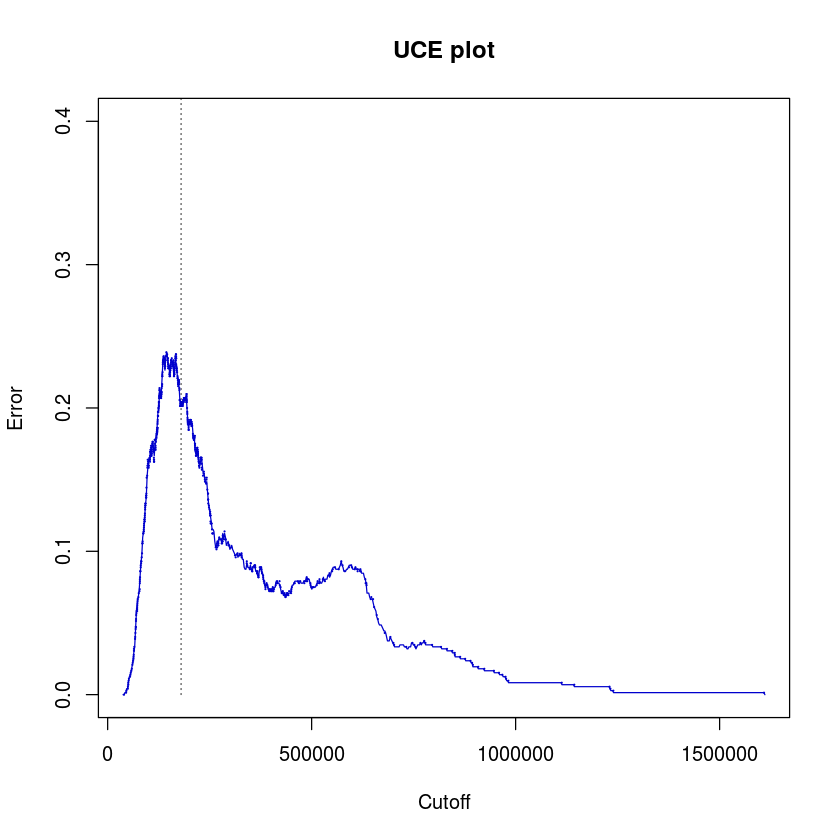

In [10]:
Reg2Class_UCE_space(xliminf=miny, xlimsup=maxy, 
                    ylimsup=PLOT_HEIGHT, test_vertical_line=median(dattest[[output_col_name]]),
                    test_horizontal_line=NULL)
for (i in 1:(num_regmodels+num_classmodels)) {  
  Reg2Class_UCE_curve(cutoffs_uniform, uce_points_list[[i]], colour=MY_COLOURS[i], linestyle=MY_STYLES[i],
                      pointcharacter=i, pointsize=1, plot_lines=TRUE, plot_points=FALSE)
  Reg2Class_UCE_curve(cutoffs_observed, oce_points_list[[i]], colour=MY_COLOURS[i], linestyle=MY_STYLES[i],
                      pointcharacter=i, pointsize=UCE_CURVE_OCE_POINTS_SIZE, plot_lines=FALSE, plot_points=TRUE)  
    legend(UCE_PLOT_LEGEND_PLACE, legend= all_names, col=MY_COLOURS, lty=MY_STYLES, pch=1:i, cex=0.75,lwd=2)
}

CE PLot

ERROR: Error in as.graphicsAnnot(legend): object 'all_names' not found


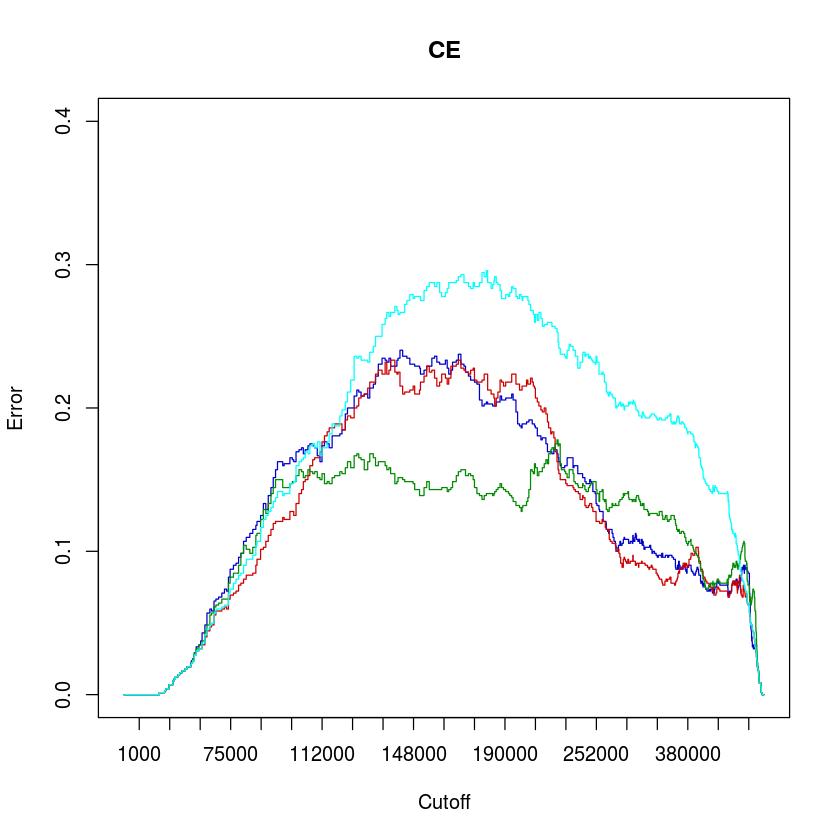

In [11]:
Reg2Class_OCE_space(ylimsup=PLOT_HEIGHT, xaxis="VALUES", ,title="CE",xlab=c( "Cutoff"), 
                    cutoffs=cutsm, test_vertical_line=NULL, test_horizontal_line=0.5, test_diagonal_lines=NULL)
  

for (i in 1:(num_regmodels+num_classmodels)) {  
  Reg2Class_OCE_curve(oce_points_list_mod[[i]], , colour=MY_COLOURS[i], linestyle=MY_STYLES[i],
                      pointcharacter=i, pointsize=OCE_CURVE_OCE_POINTS_SIZE, CURVE="CURVE")    
}

  legend(UCE_PLOT_LEGEND_PLACE, legend= all_names, col=MY_COLOURS, lty=MY_STYLES, pch=1:i, cex=0.75)



OCE curve

ERROR: Error in as.graphicsAnnot(legend): object 'all_names' not found


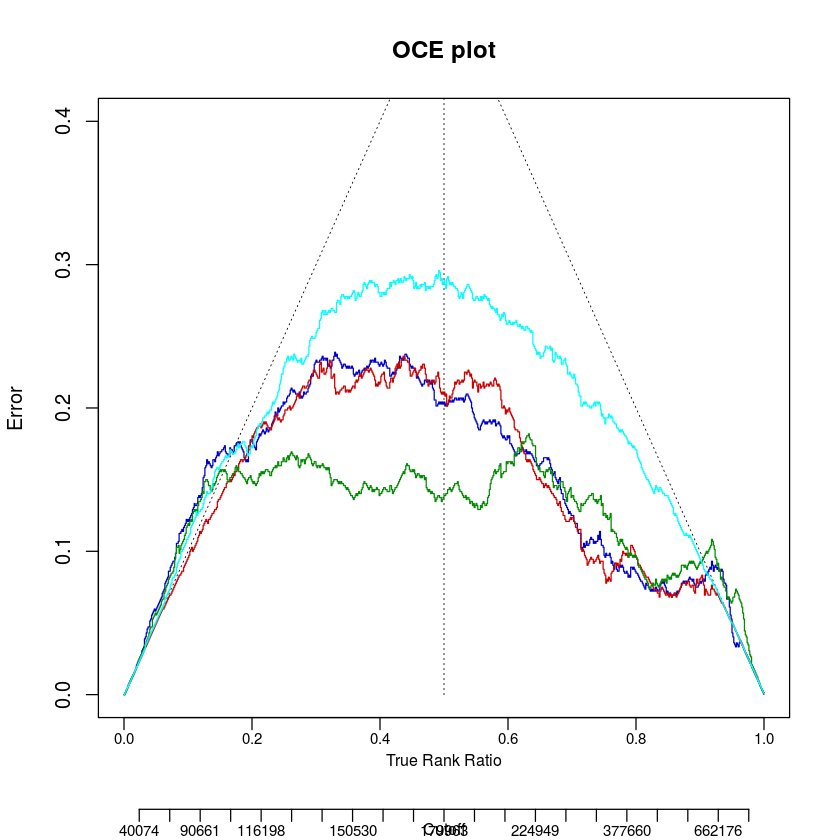

In [12]:
 Reg2Class_OCE_space(ylimsup=PLOT_HEIGHT, xaxis="BOTH", xlab=c("True Rank Ratio", "Cutoff"), 
                     cutoffs=cutoffs_observed, test_vertical_line=0.5,
                     test_horizontal_line=0.5, test_diagonal_lines=TRUE)
  
for (i in 1:(num_regmodels+num_classmodels)) {
  Reg2Class_OCE_curve(oce_points_list[[i]], , colour=MY_COLOURS[i], 
                      linestyle=MY_STYLES[i], pointcharacter=i, 
                      pointsize=OCE_CURVE_OCE_POINTS_SIZE, CURVE="CURVE")    
}


legend(OCE_PLOT_LEGEND_PLACE, legend= all_names, col=MY_COLOURS, lty=MY_STYLES, pch=1:i, cex=0.75,lwd=2)


AE diagram

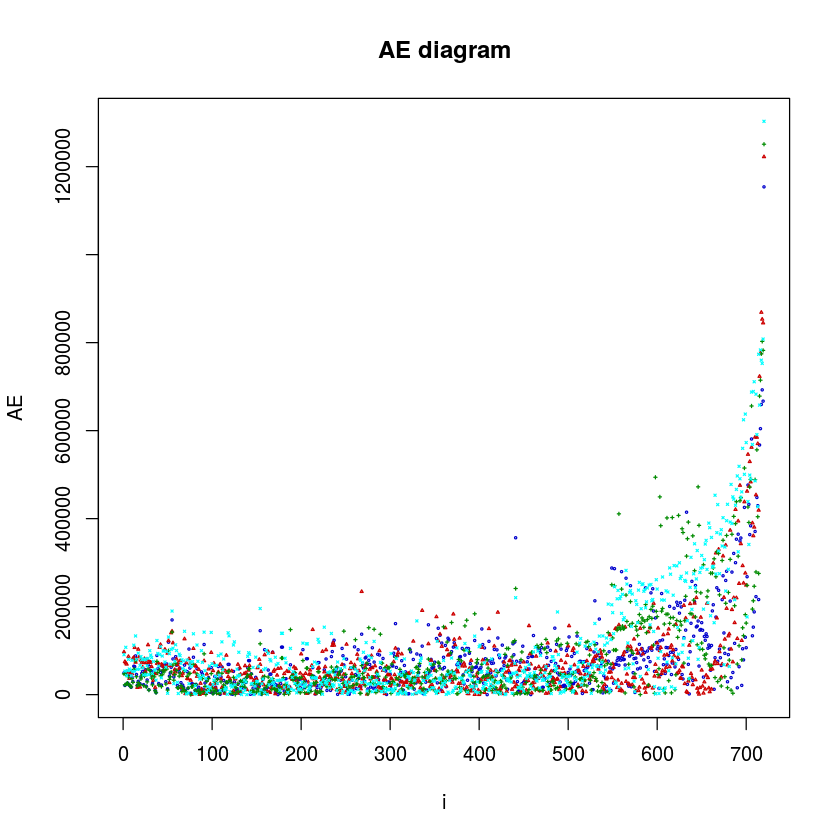

In [13]:

  max_AE <- 0
  for (i in 1:(num_regmodels)) {
    yhats <- yhat_list[[i]]
    max_AE <- max(max_AE, max(abs(yhats - test_actual)))
	if (max_AE == Inf) {
	  max_AE <- max(test_actual)
	}
  }

  Reg2Class_AE_space(dattestlen, ylimsup=max_AE)    

  
for (i in 1:(num_regmodels)) {
  Reg2Class_AE_diagram(test_actual, yhat_list[[i]], colour=MY_COLOURS[i], 
                       linestyle=MY_STYLES[i], pointcharacter=i)    
}
 
 

IR diagram

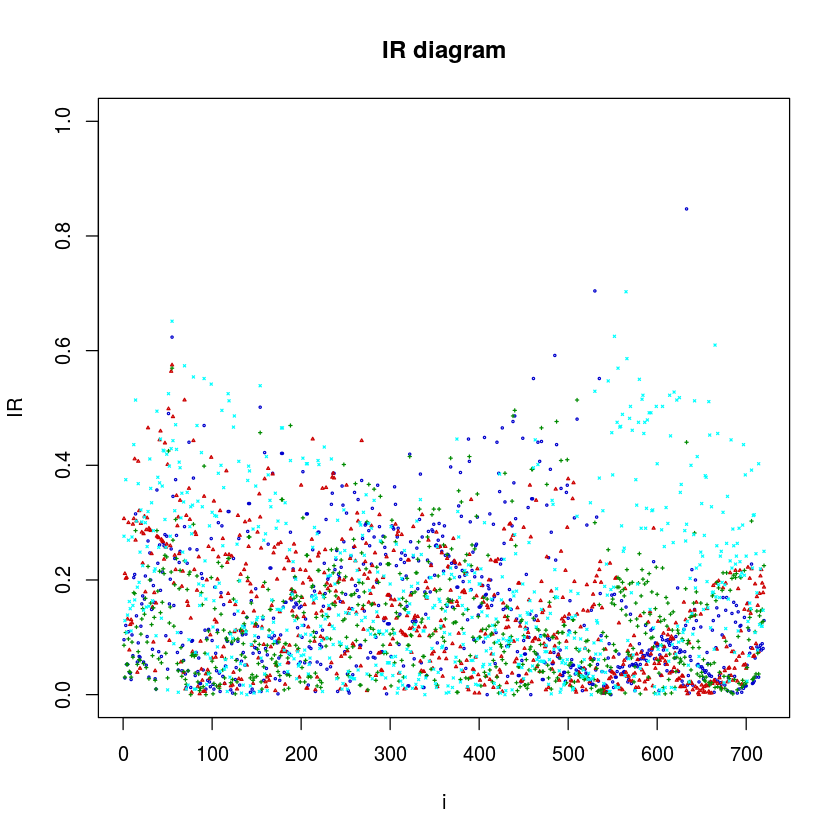

In [14]:
Reg2Class_IR_space(dattestlen)

  
for (i in 1:(num_regmodels)) {
  Reg2Class_IR_diagram(test_actual, yhat_list[[i]], colour=MY_COLOURS[i], 
                       linestyle=MY_STYLES[i], pointcharacter=i)    
}

Histogram

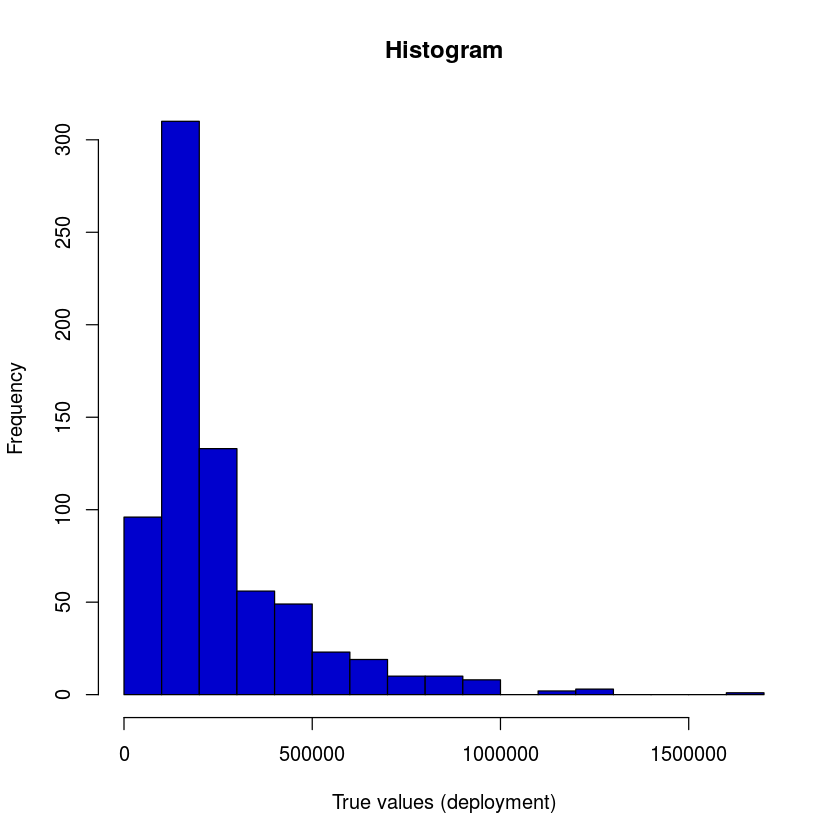

In [15]:
hist(test_actual,breaks=20, xlab="True values (deployment)", main="Histogram", col= MY_COLOURS[1])

Cumulative plot

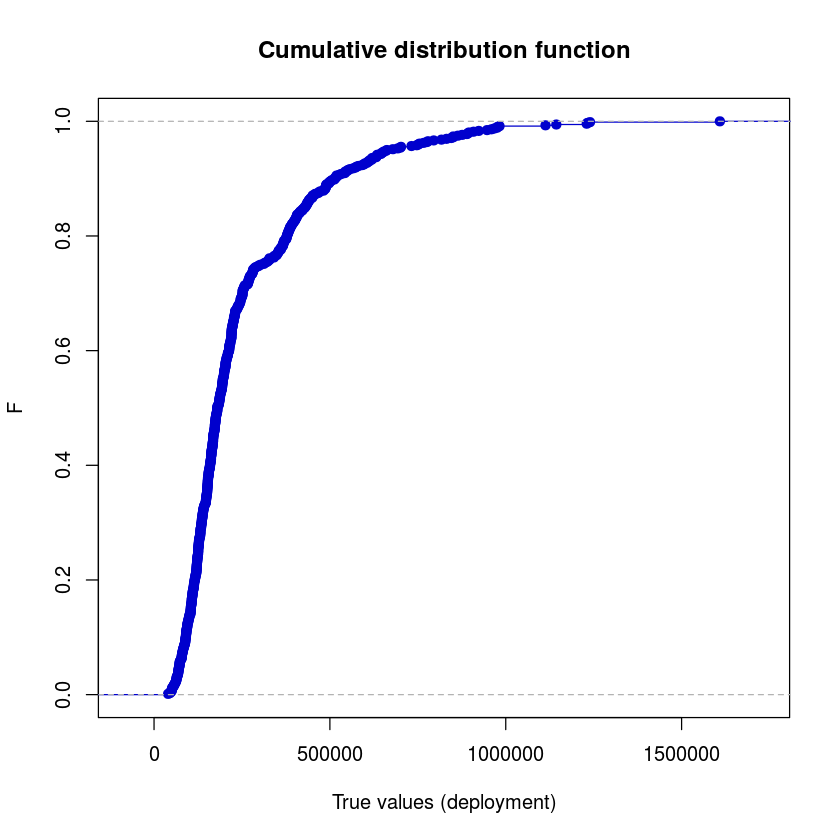

In [16]:
plot.ecdf(test_actual, xlab="True values (deployment)", ylab="F", 
          main="Cumulative distribution function", col= MY_COLOURS[1])